In [30]:
import numpy as np
import torch 
import matplotlib.pyplot as plt 
from src.libs.preprocessing import DataLoader
from tqdm import tqdm
import numpy as np
from scipy.fft import fft, ifft
from src.libs.evaluation import eval_signal, eval_all_signals
from IPython.display import Audio


In [2]:
import os
os.chdir('../')
print(os.getcwd())

/Users/Corentin/Desktop/MVA 2024-2025/Deep Learning et traitement du signal/projet_final/dlsp-denoising


In [4]:
# data path
small_data_set = False
if small_data_set:
    path_train_x = "data/input/denoising/train_small"
    path_train_y = "data/input/voice_origin/train_small"
else:
    path_train_x = "data/input/denoising/train"
    path_train_y = "data/input/voice_origin/train"

data_loader = DataLoader(path_x=path_train_x, path_y=path_train_y)
# need to normalize the data
harmonized_data = data_loader.get_harmonized_data(
    downsample=small_data_set
) 


Import summary:
- Data imported successfully!
- Number of noised samples: 2118
- Number of original samples: 2118
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.


In [13]:
path_train_x = "data/input/denoising/train"
path_train_y = "data/input/voice_origin/train"

path_test_x = "data/input/denoising/test"
path_test_y = "data/input/voice_origin/test"

print("TRAIN")
data_loader_train = DataLoader(path_x=path_train_x, path_y=path_train_y)

harmonized_data_train = data_loader_train.get_harmonized_data(
    downsample=small_data_set) 

print("______________")
print("TEST")

data_loader_test = DataLoader(path_x=path_test_x, path_y=path_test_y)
harmonized_data_test = data_loader_test.get_harmonized_data(
    downsample=small_data_set) 

TRAIN
Import summary:
- Data imported successfully!
- Number of noised samples: 2118
- Number of original samples: 2118
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: True.
______________
TEST
Import summary:
- Data imported successfully!
- Number of noised samples: 608
- Number of original samples: 782
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Frequencies in noised samples: [8000]
- Frequencies in original samples: [8000]
- Correspondance between both data sets: False.


# Baseline model : Filtre de Wiener

In [15]:
## Idée : utiliser les données du train pour construire le filtre

P_x_list = []
P_b_list = []

for x_train, y_train in tqdm(zip(harmonized_data_train.x, harmonized_data_train.y)):
    # estimation du bruit : B = X - Y
    b_train = x_train - y_train

    # transformées de Fourier des signaux bruité et propre
    X_f = np.fft.fft(x_train)
    B_f = np.fft.fft(b_train)

    # DSP
    P_x = np.abs(X_f)**2  # Spectre de puissance signal bruité
    P_b = np.abs(B_f)**2  # Spectre de puissance bruit estimé

    P_x_list.append(P_x)
    P_b_list.append(P_b)

# On estime le bruit moyen
P_x_mean = np.mean(P_x_list, axis=0)  # Moyennesur signaux bruités
P_b_mean = np.mean(P_b_list, axis=0)  # Moyenne sur bruit

# Filtre de Wiener comme dans le cours : H(f) = (P_x(f) - P_b(f)) / P_x(f)
H_f = (P_x_mean - P_b_mean) / P_x_mean


2118it [00:33, 63.03it/s]


### Example 

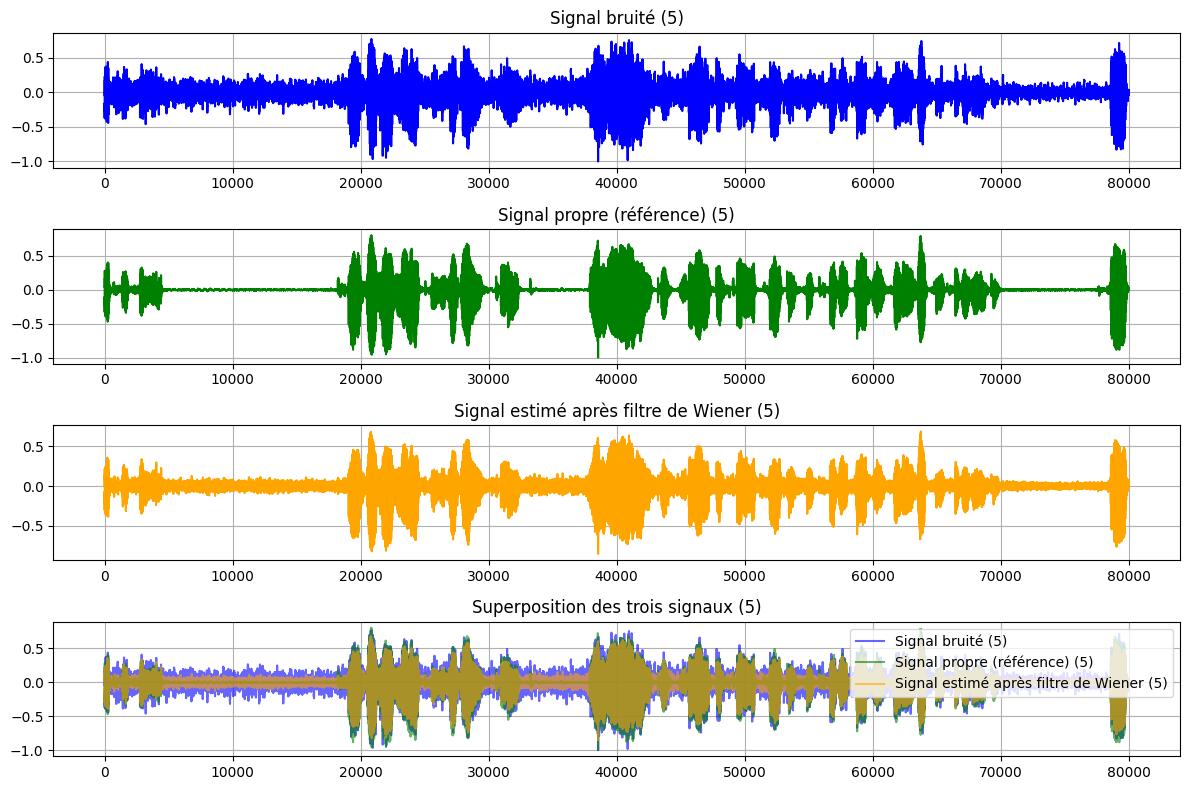

Signal bruité : 


Signal débruité : 


Signal target : 


In [32]:
i = 5 # exemple à choisir
x_test = harmonized_data_test.x[i]

# Appliquer le filtre de Wiener 
X_f_test = np.fft.fft(x_test)
X_f_test_est = H_f * X_f_test
x_test_est = np.fft.ifft(X_f_test_est)

# Affichage 
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(np.real(x_test), label=f'Signal bruité ({i})', color="blue")
plt.title(f'Signal bruité ({i})')
plt.grid()

plt.subplot(4, 1, 2)
plt.plot(np.real(harmonized_data_test.y[i]), label=f'Signal propre (référence) ({i})', color="green")
plt.title(f'Signal propre (référence) ({i})')
plt.grid()

plt.subplot(4, 1, 3)
plt.plot(np.real(x_test_est), label=f'Signal estimé après filtre de Wiener ({i})', color="orange")
plt.title(f'Signal estimé après filtre de Wiener ({i})')
plt.grid()

plt.subplot(4, 1, 4)
plt.plot(np.real(x_test), label=f'Signal bruité ({i})', color="blue", alpha=0.6)
plt.plot(np.real(harmonized_data_test.y[i]), label=f'Signal propre (référence) ({i})', color="green", alpha=0.6)
plt.plot(np.real(x_test_est), label=f'Signal estimé après filtre de Wiener ({i})', color="orange", alpha=0.6)
plt.title(f'Superposition des trois signaux ({i})')
plt.legend(loc="upper right")
plt.grid()

plt.tight_layout()
plt.show()

print("Signal bruité : ")
display(Audio(np.real(x_test), rate=8000))

print("Signal débruité : ")
display(Audio(np.real(x_test_est), rate=8000))

print("Signal target : ")
display(Audio(np.real(harmonized_data_test.y[i]), rate=8000))


In [22]:
signaux_debruites = []

for i, x_test in tqdm(enumerate(harmonized_data_test.x)):
    # On applique le filtre de Wiener 
    X_f_test = np.fft.fft(x_test)
    X_f_test_est = H_f * X_f_test
    x_test_est = np.fft.ifft(X_f_test_est)

    signaux_debruites.append(np.real(x_test_est))


608it [00:02, 208.42it/s]


In [23]:
def eval_all_signals(list_signals_pred, list_signals_target, f_sampling):
    " Iterations sur tous les signaux "
    MSE = []
    RMSE = []
    SNR = []
    STOI_results = []
    PESQ_results = []
    for i, signal_pred in tqdm(enumerate(list_signals_pred), total=len(list_signals_pred)):
        signal_target = list_signals_target[i]
        mse, rmse, snr, stoi_result, pesq_result = eval_signal(signal_pred, signal_target, f_sampling)
        MSE.append(mse)
        RMSE.append(rmse)
        SNR.append(snr)
        STOI_results.append(stoi_result)
        PESQ_results.append(pesq_result)
    return MSE, RMSE, SNR, STOI_results, PESQ_results


def summary_eval(MSE, RMSE, SNR, STOI_results, PESQ_results):
    print("Metric : mean (std)")
    print("___________________")
    print(f"MSE   : {np.mean(MSE):.4f} ({np.std(MSE):.4f})")
    print(f"RMSE  : {np.mean(RMSE):.4f} ({np.std(RMSE):.4f})")
    print(f"SNR   : {np.mean(SNR):.4f} ({np.std(SNR):.4f})")
    print(f"STOI  : {np.mean(STOI_results):.4f} ({np.std(STOI_results):.4f})")
    print(f"PESQ  : {np.mean(PESQ_results):.4f} ({np.std(PESQ_results):.4f})")

In [25]:
MSE, RMSE, SNR, STOI_results, PESQ_results = eval_all_signals(signaux_debruites, harmonized_data_test.y, 8000)
summary_eval(MSE, RMSE, SNR, STOI_results, PESQ_results)

100%|██████████| 608/608 [01:22<00:00,  7.39it/s]

Metric : mean (std)
___________________
MSE   : 0.0009 (0.0011)
RMSE  : 0.0258 (0.0143)
SNR   : 14.8739 (4.0047)
STOI  : 0.9314 (0.0684)
PESQ  : 2.6330 (0.6391)


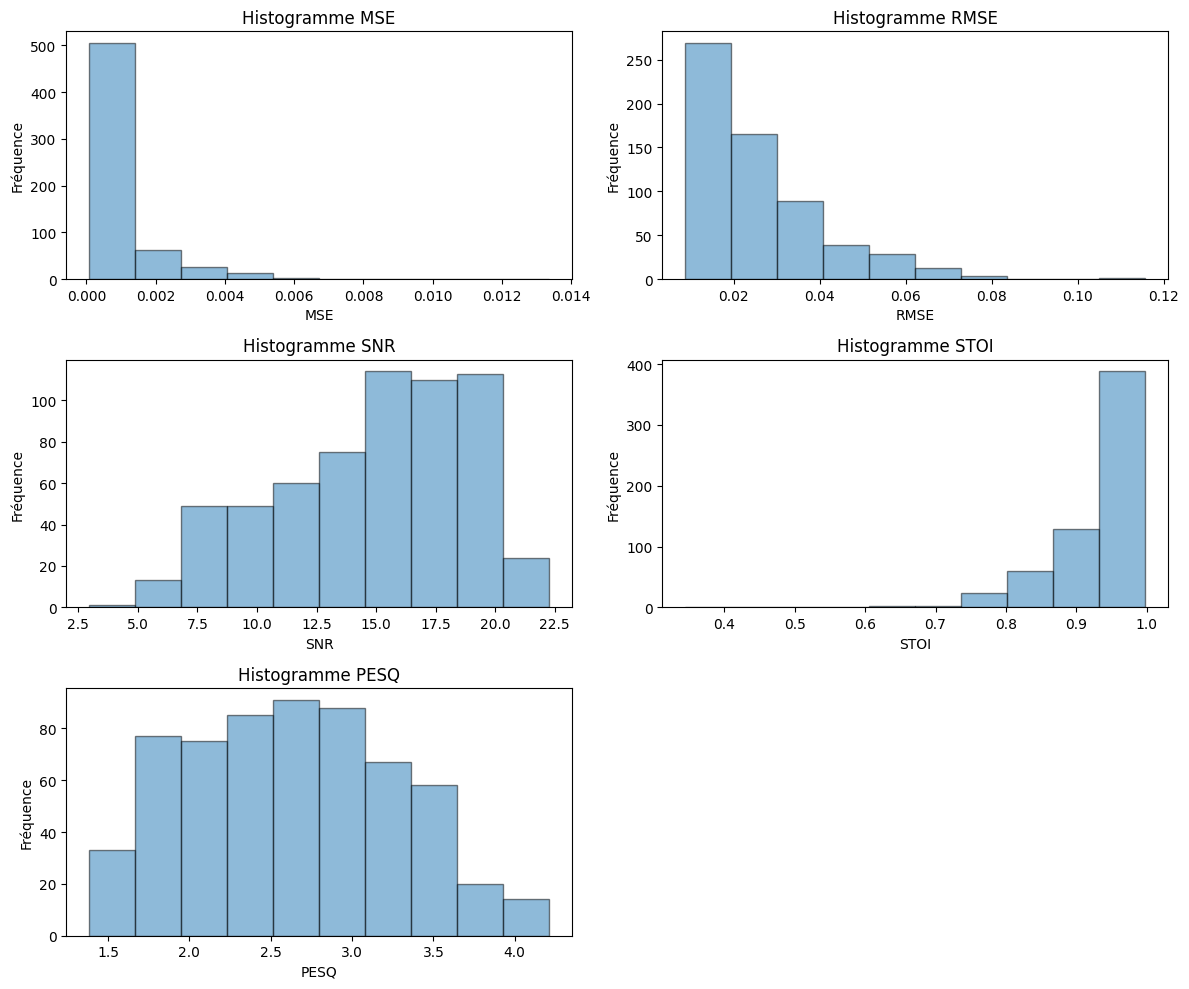

In [26]:
fig, axs = plt.subplots(3, 2, figsize=(12, 10)) 

# Histogramme MSE
axs[0, 0].hist(MSE, bins=10, edgecolor='black', alpha=0.5)
axs[0, 0].set_title('Histogramme MSE')
axs[0, 0].set_xlabel('MSE')
axs[0, 0].set_ylabel('Fréquence')

# Histogramme RMSE
axs[0, 1].hist(RMSE, bins=10, edgecolor='black', alpha=0.5)
axs[0, 1].set_title('Histogramme RMSE')
axs[0, 1].set_xlabel('RMSE')
axs[0, 1].set_ylabel('Fréquence')

# Histogramme SNR
axs[1, 0].hist(SNR, bins=10, edgecolor='black', alpha=0.5)
axs[1, 0].set_title('Histogramme SNR')
axs[1, 0].set_xlabel('SNR')
axs[1, 0].set_ylabel('Fréquence')

# Histogramme STOI
axs[1, 1].hist(STOI_results, bins=10, edgecolor='black', alpha=0.5)
axs[1, 1].set_title('Histogramme STOI')
axs[1, 1].set_xlabel('STOI')
axs[1, 1].set_ylabel('Fréquence')

# Histogramme PESQ
axs[2, 0].hist(PESQ_results, bins=10, edgecolor='black', alpha=0.5)
axs[2, 0].set_title('Histogramme PESQ')
axs[2, 0].set_xlabel('PESQ')
axs[2, 0].set_ylabel('Fréquence')

axs[2, 1].axis('off')
plt.tight_layout()
plt.show()